In [1]:
import os
%load_ext autoreload
%autoreload 1
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%aimport models.adaptation
%aimport HookedRecursiveCNN
%aimport modules.divisive_norm
from models.adaptation import Adaptation
from HookedRecursiveCNN import HookedRecursiveCNN
from utils.visualization import visualize_first_batch_with_timesteps
from torch.utils.data import DataLoader
from models.noisy_dataloader import NoisyTemporalDataset
from functools import partial
from utils.transforms import RandomRepeatedNoise, MeanFlat
from modules.divisive_norm_group import DivisiveNormGroup
from modules.divisive_norm import DivisiveNorm
from modules.exponential_decay import ExponentialDecay
from modules.lateral_recurrence import LateralRecurrence
from pytorch_lightning.loggers import CSVLogger
import torchvision.transforms as transforms
import json
import pytorch_lightning as pl
import torch

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/

Train DataLoader: 3750 batches


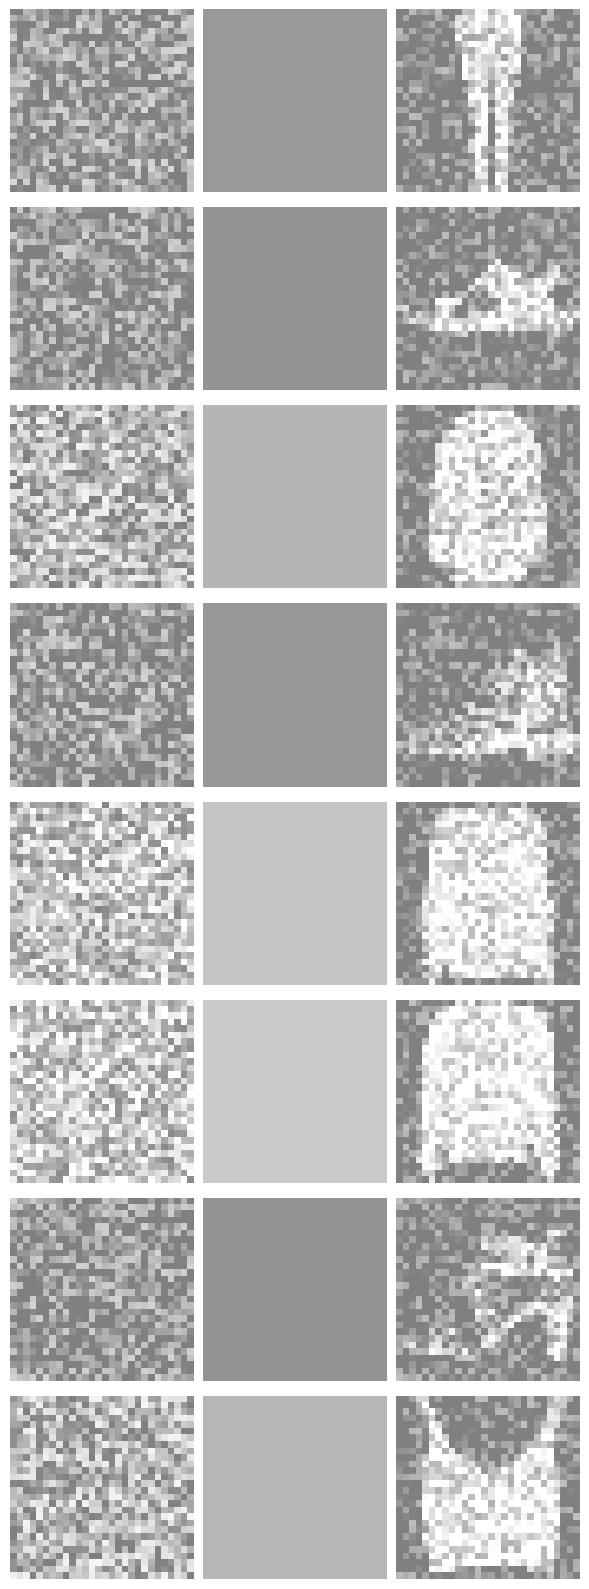

In [11]:
from modules.div_norm_channel import DivisiveNormChannel

with open('config.json', 'r') as f:
    config = json.load(f)

dataset = config["dataset"]
if config["dataset"] == 'fashion_mnist':
    layer_kwargs = config["layer_kwargs_fmnist"]
elif config["dataset"] == 'cifar10':
    layer_kwargs = config["layer_kwargs_cifar10"]


# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

logger = CSVLogger(config["log_dir"], name=config["log_name"])

if config["adaptation_module"] == 'LateralRecurrence':
    adaptation_module = LateralRecurrence
    adaptation_kwargs = config["adaptation_kwargs_lateral"]
elif config["adaptation_module"] == 'ExponentialDecay':
    adaptation_module = ExponentialDecay
    adaptation_kwargs = config["adaptation_kwargs_additive"]
elif config["adaptation_module"] == 'DivisiveNorm':
    adaptation_module = DivisiveNorm
    adaptation_kwargs = config["adaptation_kwargs_div_norm"]
elif config["adaptation_module"] == 'DivisiveNormGroup':
    adaptation_module = DivisiveNormGroup
    adaptation_kwargs = config["adaptation_kwargs_div_norm_group"]
elif config["adaptation_module"] == 'DivisiveNormChannel':
    adaptation_module = DivisiveNormChannel
    adaptation_kwargs = config["adaptation_kwargs_div_norm_channel"]
else:
    raise ValueError(f'Adaptation module {config["adaptation_module"]} not implemented')

loaders = []
for contrast in [0.2, 0.4, 0.6, 0.8, 1.]:
    train_sets = []
    test_sets = []
    for repeat_noise_at_test in [True, False]:
        noise_transformer = RandomRepeatedNoise(contrast=contrast,
                                                repeat_noise_at_test=repeat_noise_at_test)
        noise_transformer_test = partial(noise_transformer, stage='test')
        first_in_line_transformer = partial(noise_transformer, stage='test', first_in_line=True)
    
        timestep_transforms = [MeanFlat()] + [noise_transformer] * 6 + [MeanFlat()] + [
            first_in_line_transformer] + [noise_transformer_test]
        timestep_transforms = [noise_transformer] + [MeanFlat()] + [first_in_line_transformer]
        # Create instances of the Fashion MNIST dataset
        train_sets.append(NoisyTemporalDataset('train', dataset=dataset, transform=transform,
                                               img_to_timesteps_transforms=timestep_transforms))
        test_sets.append(NoisyTemporalDataset('test', dataset=dataset, transform=transform,
                                              img_to_timesteps_transforms=timestep_transforms))
    train_dataset = torch.utils.data.ConcatDataset(train_sets)
    test_dataset = torch.utils.data.ConcatDataset(test_sets)
    noise_test_dataloader = [torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=3)
                             for test_set in test_sets]
    loaders.append(noise_test_dataloader)

# Create the DataLoaders for the Fashion MNIST dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

# Print the length of the DataLoader
print(f'Train DataLoader: {len(train_loader)} batches')
#print(f'Test DataLoader: {len(test_loader)} batches')

# Visualize the first batch of images
visualize_first_batch_with_timesteps(train_loader, 8)

In [3]:
hooked_model = HookedRecursiveCNN(t_steps=10, layer_kwargs=layer_kwargs,
                                  adaptation_module=adaptation_module,
                                  adaptation_kwargs=adaptation_kwargs)
l, cache = hooked_model.run_with_cache(next(iter(train_loader))[0])
model = Adaptation(hooked_model, lr=config["lr"],)

# checkpoint_path = f"learned_models/t=3_ExponentialDecay_contrast_random_repeat_noise_both_epoch_4.ckpt"
checkpoint_path = f"learned_models/t=3_DivisiveNorm_contrast_random_repeat_noise_both_epoch_3.ckpt"
checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Load checkpoint
state_dict = checkpoint['state_dict']  # Extract state dict
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
# baseline model
hooked_baseline_model = HookedRecursiveCNN(t_steps=10, layer_kwargs=layer_kwargs,
                                  adaptation_module=adaptation_module,
                                  adaptation_kwargs=adaptation_kwargs)
baseline_model = Adaptation(hooked_baseline_model, lr=config["lr"],)

checkpoint_path = f"learned_models/notime_baseline_DivisiveNorm_contrast_1.0_repeat_noise_False_epoch_8.ckpt"
checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Load checkpoint
state_dict = checkpoint['state_dict']  # Extract state dict
baseline_model.load_state_dict(state_dict)

import pandas as pd

trainer = pl.Trainer(max_epochs=1)
results = {'contrast': [], 'repeat_noise_at_test': [], 'test_loss': [], 'test_acc': []}
for i, (rep_noise_loader, wo_rep_loader) in enumerate(loaders):
    res = trainer.test(baseline_model, dataloaders=rep_noise_loader)
    results['contrast'].append((i + 1) / 5)
    results['repeat_noise_at_test'].append(True)
    results['test_loss'].append(res[0]['test_loss'])
    results['test_acc'].append(res[0]['test_acc'])
    res = trainer.test(baseline_model, dataloaders=wo_rep_loader)
    results['contrast'].append((i + 1) / 5)
    results['repeat_noise_at_test'].append(False)
    results['test_loss'].append(res[0]['test_loss'])
    results['test_acc'].append(res[0]['test_acc'])
acc_df = pd.DataFrame(results)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.lineplot(data=acc_df, x='contrast', y='test_acc', hue='repeat_noise_at_test', palette='Set1', )
plt.title('Baseline accuracy trained on contrast = 1 and tested on different contrasts')
sns.despine()

RuntimeError: Error(s) in loading state_dict for Adaptation:
	Missing key(s) in state_dict: "model.adapt_layers.0.beta", "model.adapt_layers.1.beta", "model.adapt_layers.2.beta". 
	Unexpected key(s) in state_dict: "model.adapt_layers.0.K", "model.adapt_layers.0.sigma", "model.adapt_layers.1.K", "model.adapt_layers.1.sigma", "model.adapt_layers.2.K", "model.adapt_layers.2.sigma". 

In [8]:
trainer = pl.Trainer(max_epochs=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
import pandas as pd

results = {'contrast': [], 'repeat_noise_at_test': [], 'test_loss': [], 'test_acc': []}
for i, (rep_noise_loader, wo_rep_loader) in enumerate(loaders):
    res = trainer.test(model, dataloaders=rep_noise_loader)
    results['contrast'].append((i + 1) / 5)
    results['repeat_noise_at_test'].append(True)
    results['test_loss'].append(res[0]['test_loss'])
    results['test_acc'].append(res[0]['test_acc'])
    res = trainer.test(model, dataloaders=wo_rep_loader)
    results['contrast'].append((i + 1) / 5)
    results['repeat_noise_at_test'].append(False)
    results['test_loss'].append(res[0]['test_loss'])
    results['test_acc'].append(res[0]['test_acc'])
acc_df = pd.DataFrame(results)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5375999808311462     │
│         test_loss         │    1.4018524885177612     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.48030000925064087    │
│         test_loss         │    1.4551502466201782     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6358000040054321     │
│         test_loss         │    1.1341509819030762     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.592199981212616     │
│         test_loss         │    1.1591532230377197     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6194000244140625     │
│         test_loss         │    1.1156213283538818     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5705999732017517     │
│         test_loss         │     1.14352285861969      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5692999958992004     │
│         test_loss         │    1.2197203636169434     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5181000232696533     │
│         test_loss         │    1.2661268711090088     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5091000199317932     │
│         test_loss         │    1.3658841848373413     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4611999988555908     │
│         test_loss         │    1.4218703508377075     │
└───────────────────────────┴───────────────────────────┘

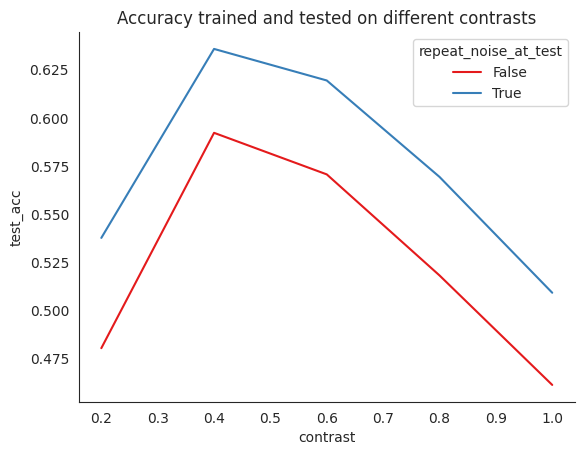

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.lineplot(data=acc_df, x='contrast', y='test_acc', hue='repeat_noise_at_test', palette='Set1', )
plt.title('Accuracy trained and tested on different contrasts')
sns.despine()

In [7]:
hooked_model.adapt_layers[0].sigma

Parameter containing:
tensor(0.2311, requires_grad=True)

In [13]:
noise_dict = {i: i for i in range(10000)}
different_noise_dict = {i: i + 1 for i in range(10000)}

noise_transformer = RandomRepeatedNoise(contrast=.2, repeat_noise_at_test=False,
                                        noise_seed=different_noise_dict, noise_seed_test=noise_dict)
noise_transformer_test = partial(noise_transformer, stage='test')
timestep_transforms = [MeanFlat()] + [noise_transformer] * 6 + [MeanFlat()] + [noise_transformer_test] * 2  # no first in line transformer because test noise dict is already given
timestep_transforms = [noise_transformer] + [MeanFlat()] + [noise_transformer_test]
seed_new_set = NoisyTemporalDataset('test', dataset=dataset, transform=transform,
                                      img_to_timesteps_transforms=timestep_transforms)

noise_transformer = RandomRepeatedNoise(contrast=.2, repeat_noise_at_test=True,
                                        noise_seed=noise_dict, noise_seed_test=noise_dict)
noise_transformer_test = partial(noise_transformer, stage='test')
timestep_transforms = [noise_transformer] + [MeanFlat()] + [noise_transformer_test]
seed_rep_set = NoisyTemporalDataset('test', dataset=dataset, transform=transform,
                                      img_to_timesteps_transforms=timestep_transforms)


Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)



100%|██████████| 100/100 [00:01<00:00, 53.34it/s][A

100%|██████████| 100/100 [00:01<00:00, 59.85it/s][A

100%|██████████| 100/100 [00:01<00:00, 61.46it/s][A


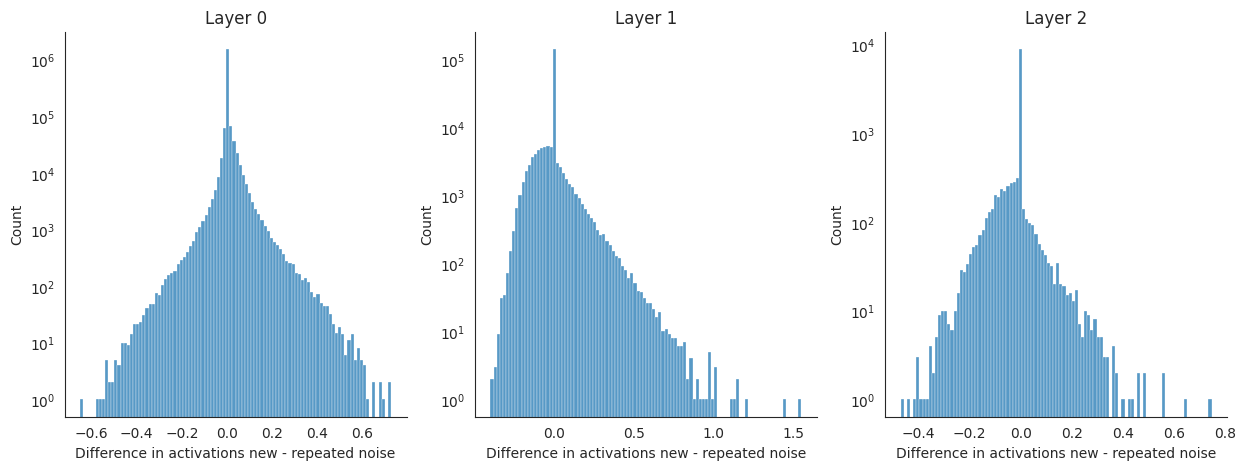

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for layer in range(3):
    diff_actvs = []
    for i in tqdm(range(100)):
        _, cache_rep = hooked_model.run_with_cache(seed_rep_set[i][0].unsqueeze(0))
        _, cache_new = hooked_model.run_with_cache(seed_new_set[i][0].unsqueeze(0))
        diff_actvs.append((cache_new[f'hks.adapt_{layer}_2'] - cache_rep[f'hks.adapt_{layer}_2']).flatten())
    diff_actvs = torch.cat(diff_actvs)
    
    sns.histplot(diff_actvs.flatten(), bins=100, ax=axes[layer])
    # log y
    axes[layer].set_yscale('log')
    axes[layer].set_title('Layer ' + str(layer))
    axes[layer].set_xlabel('Difference in activations new - repeated noise')
    sns.despine()
    diff_actvs.mean()

In [10]:
seed_rep_set[0][0].shape

torch.Size([3, 1, 28, 28])

tensor(-0.0127)

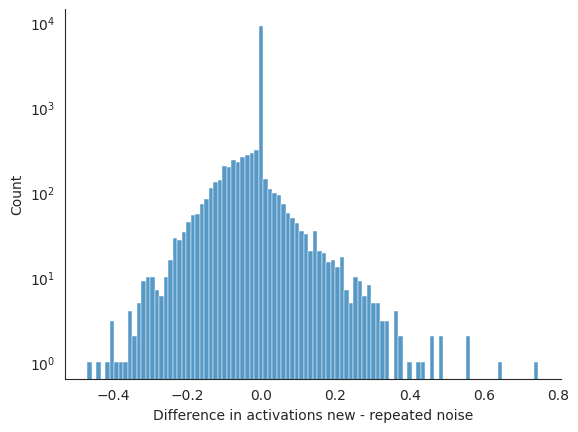

In [11]:
sns.histplot(diff_actvs.flatten(), bins=100)
# log y
plt.yscale('log')
plt.xlabel('Difference in activations new - repeated noise')
sns.despine()
diff_actvs.mean()

In [12]:
from matplotlib import pyplot as plt

def plot_activations(cache, f_map=0):
    n_timesteps = 3
    fig, axes = plt.subplots(6, n_timesteps, figsize=(1.5 * n_timesteps, 9))
    
    for layer in range(0, 6, 2):
        min_conv = min(cache[f'hks.conv_{layer // 2}_{i}'][0, f_map].min().item() for i in range(n_timesteps))
        max_conv = max(cache[f'hks.conv_{layer // 2}_{i}'][0, f_map].max().item() for i in range(n_timesteps))
        min_adapt = min(cache[f'hks.adapt_{layer // 2}_{i}'][0, f_map].min().item() for i in range(n_timesteps))
        max_adapt = max(cache[f'hks.adapt_{layer // 2}_{i}'][0, f_map].max().item() for i in range(n_timesteps))
        
        for i in range(n_timesteps):
            ax_conv = axes[layer, i]
            im_conv = ax_conv.imshow(cache[f'hks.conv_{layer // 2}_{i}'][0, f_map].detach().numpy(),
                                     vmin=min_conv, vmax=max_conv)
            ax_adapt = axes[layer + 1, i]
            im_adapt = ax_adapt.imshow(cache[f'hks.adapt_{layer // 2}_{i}'][0, f_map].detach().numpy(),
                                       vmin=min_adapt, vmax=max_adapt)
            if i == 0:
                axes[layer, i].set_ylabel(f'conv_{layer // 2}')
                axes[layer + 1, i].set_ylabel(f'adapt_{layer // 2}')
            
            ax_conv.set_xticks([])
            ax_conv.set_yticks([])
            ax_adapt.set_xticks([])
            ax_adapt.set_yticks([])

        # Add a larger colorbar at the end of each row
        fig.colorbar(im_conv, ax=axes[layer, :], orientation='horizontal', fraction=0.06, pad=0.1, aspect=30)
        fig.colorbar(im_adapt, ax=axes[layer + 1, :], orientation='horizontal', fraction=0.06, pad=0.1, aspect=30)


In [13]:
def plot_layer_features(cache, type_='adapt', layer=0):
    n_timesteps = 3
    n_features = 32
    fig, axes = plt.subplots(n_features, n_timesteps, figsize=(1.5 * n_timesteps, 1.3 * n_features))
    
    for f_map in range(n_features):
        min_conv =  min(cache[f'hks.{type_}_{layer}_{i}'][0, f_map].min().item() for i in range(n_timesteps))
        max_conv =  max(cache[f'hks.{type_}_{layer}_{i}'][0, f_map].max().item() for i in range(n_timesteps))
        min_conv, max_conv = 0., 0.5
        
        for i in range(n_timesteps):
            ax_conv = axes[f_map, i]
            im_conv = ax_conv.imshow(cache[f'hks.{type_}_{layer}_{i}'][0, f_map].detach().numpy(),
                                     vmin=min_conv, vmax=max_conv)
            if i == 0:
                axes[f_map, i].set_ylabel(f'{type_}_{layer}')
            
            ax_conv.set_xticks([])
            ax_conv.set_yticks([])

        # Add a larger colorbar at the end of each row
        fig.colorbar(im_conv, ax=axes[f_map, :], orientation='horizontal', fraction=0.06, pad=0.1, aspect=30)

In [14]:
_, cache_rep = hooked_model.run_with_cache(seed_rep_set[0][0].unsqueeze(0))
_, cache_new = hooked_model.run_with_cache(seed_new_set[0][0].unsqueeze(0))

In [15]:
seed_new_set[2][0].shape

torch.Size([3, 1, 28, 28])

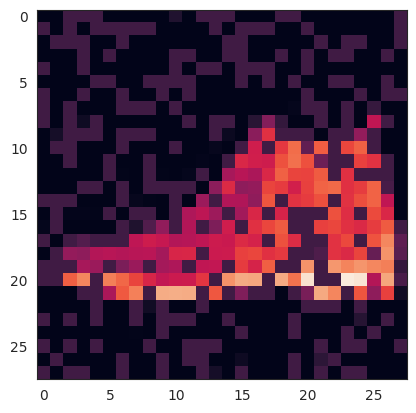

In [16]:
# swap axes
img = seed_rep_set[0][0].squeeze(1).permute(1, 2, 0)
plt.imshow(img[..., 2] - img[..., 0])

In [17]:
cache_rep.keys()

dict_keys(['hks.conv_0_0', 'hks.adapt_0_0', 'hks.conv_1_0', 'hks.adapt_1_0', 'hks.conv_2_0', 'hks.adapt_2_0', 'hook_fc1', 'hks.conv_0_1', 'hks.adapt_0_1', 'hks.conv_1_1', 'hks.adapt_1_1', 'hks.conv_2_1', 'hks.adapt_2_1', 'hks.conv_0_2', 'hks.adapt_0_2', 'hks.conv_1_2', 'hks.adapt_1_2', 'hks.conv_2_2', 'hks.adapt_2_2'])

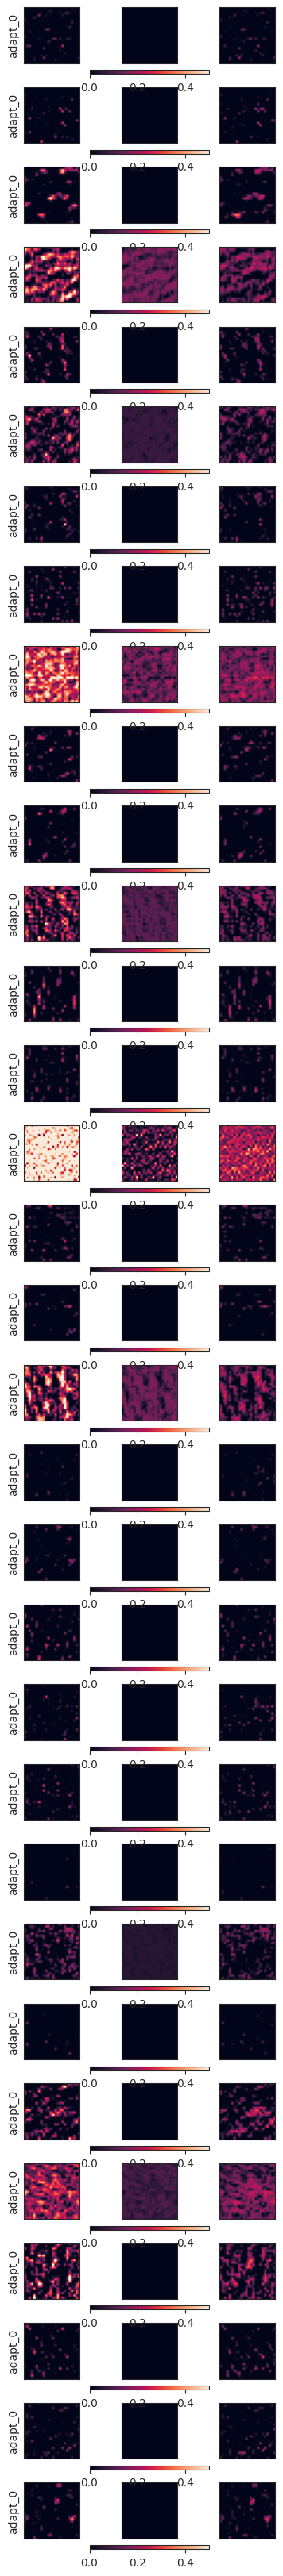

In [18]:
#x, y = next(iter(noise_test_dataloader[0]))
#l, cache = hooked_model.run_with_cache(x)
plot_layer_features(cache_rep, layer=0)

In [19]:
cache_new['hks.conv_0_2']

tensor([[[[-0.2098, -0.2549, -0.4517,  ..., -0.1287, -0.2853, -0.2891],
          [-0.2523, -0.3014, -0.1279,  ...,  0.0255, -0.0864, -0.0101],
          [-0.3946, -0.0832, -0.1440,  ..., -0.4165, -0.2768, -0.2408],
          ...,
          [-0.1151, -0.4684, -0.2852,  ..., -0.0422, -0.4088,  0.1315],
          [-0.1852, -0.0817, -0.1966,  ..., -0.1329, -0.2337, -0.2334],
          [-0.1328, -0.2152, -0.0051,  ..., -0.3896, -0.0186, -0.3650]],

         [[-0.3107, -0.1381, -0.0788,  ..., -0.3116, -0.5030, -0.2896],
          [-0.5330, -0.2980, -0.0538,  ..., -0.6759, -0.7230, -0.4215],
          [-0.1068, -0.1226, -0.2781,  ..., -0.3619, -0.3848, -0.5770],
          ...,
          [-0.1533, -0.3552, -0.5421,  ..., -0.0857, -0.2980, -0.5972],
          [-0.3286, -0.3502, -0.4153,  ..., -0.2687, -0.2201, -0.1695],
          [-0.0973, -0.1791, -0.5213,  ..., -0.3097, -0.3601, -0.3415]],

         [[-0.3924, -0.4071, -0.1932,  ..., -0.0148,  0.1673, -0.0249],
          [-0.4036, -0.2372, -

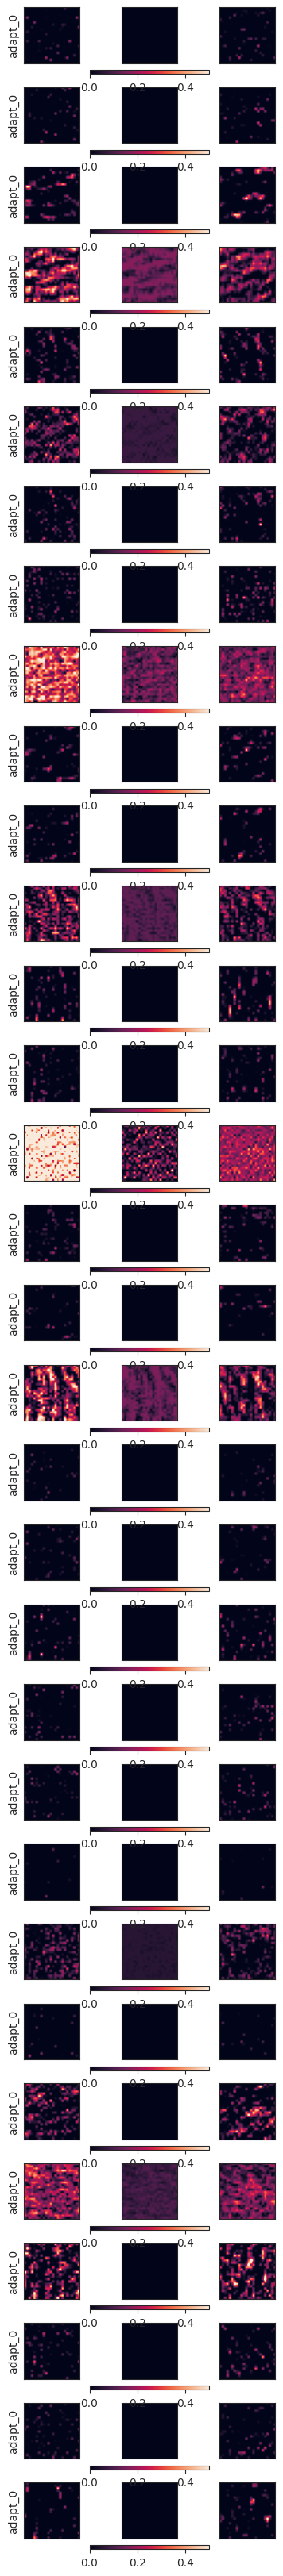

In [20]:
plot_layer_features(cache_new, layer=0)

In [131]:
def cosine_sim(tensor_a, tensor_b):
    return torch.nn.functional.cosine_similarity(tensor_a.unsqueeze(0), tensor_b.unsqueeze(0))


cosine_sim(cache_new['hks.conv_1_2'].flatten(), cache_rep['hks.conv_1_2'].flatten())

tensor([0.7550])

In [142]:
a = torch.rand(3000)
b = torch.rand(3000) - 0.5
cosine_sim(a, b)

tensor([-0.0125])

In [140]:
torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))

tensor([0.7466])

In [141]:
a

tensor([0.5297, 0.9818, 0.9819,  ..., 0.6827, 0.6425, 0.3630])

In [124]:
cache_new['hks.conv_1_2'].flatten()

tensor([-1.6854, -1.4971, -1.6182,  ..., -0.7539, -0.7196, -0.7858])

In [130]:
cache_rep['hks.conv_1_2'][0, 0, 0, 0] = 1

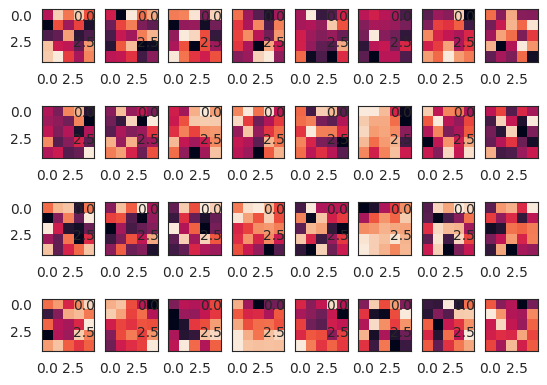

In [79]:
fig, axes = plt.subplots(4, 8)
for i in range(4):
    for j in range(8):
        axes[i, j].imshow(hooked_model.conv_layers[1].weight[i * 8 + j, 0].detach().numpy())

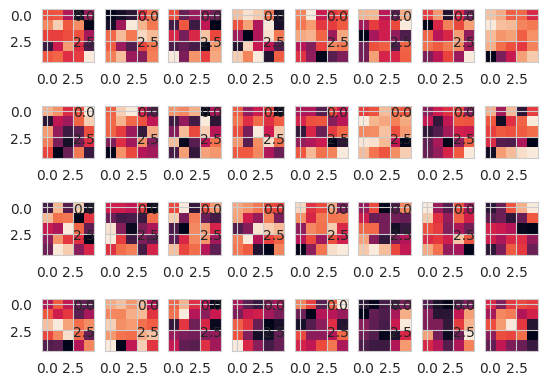

In [16]:
fig, axes = plt.subplots(4, 8)
for i in range(4):
    for j in range(8):
        axes[i, j].imshow(hooked_model.conv_layers[1].weight[i * 8 + j, 1].detach().numpy())

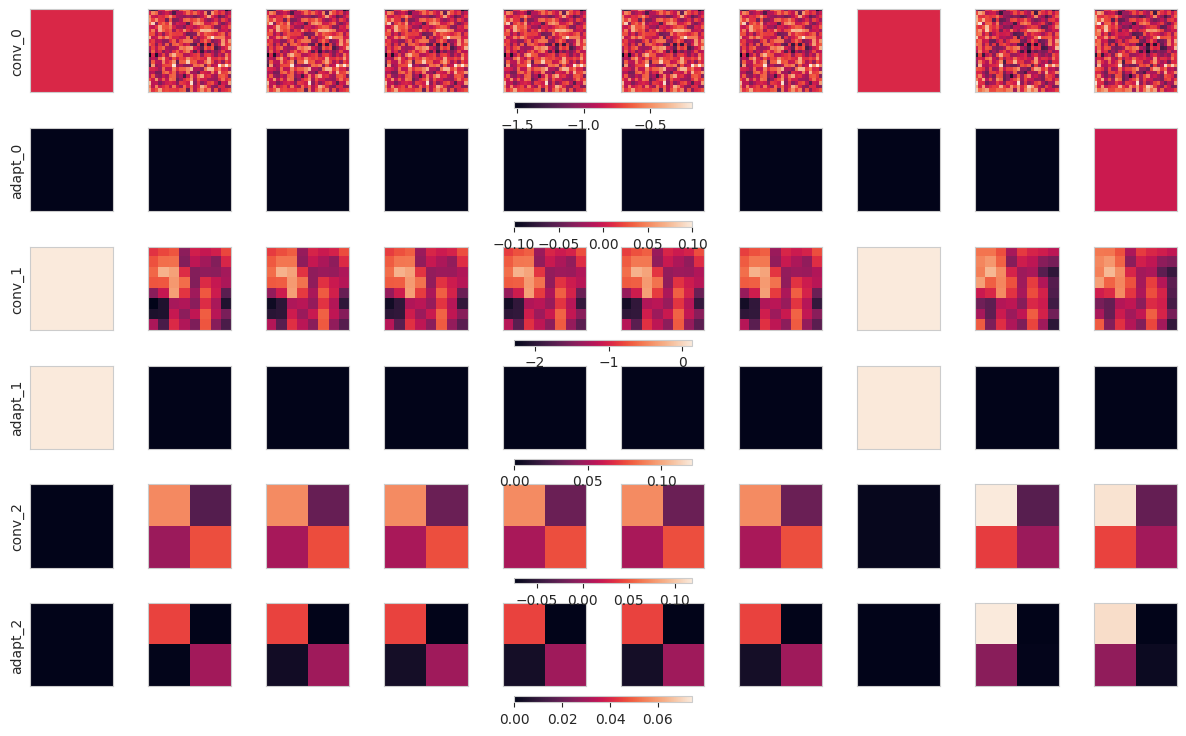

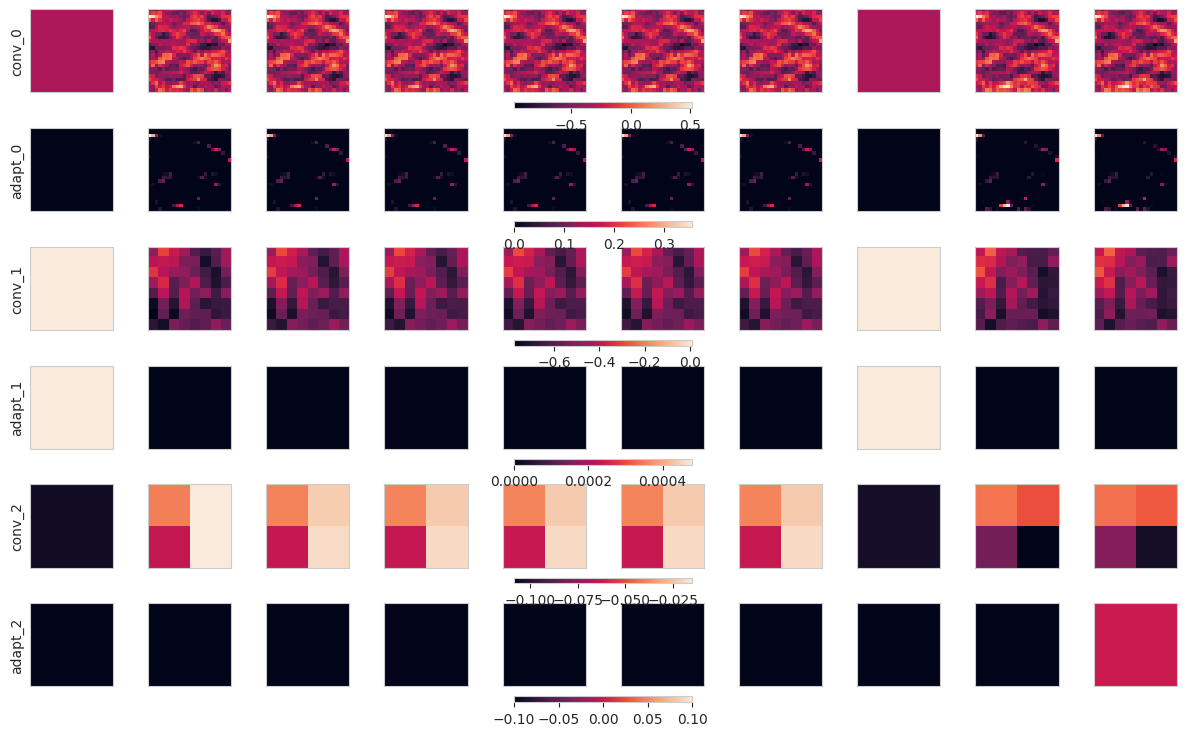

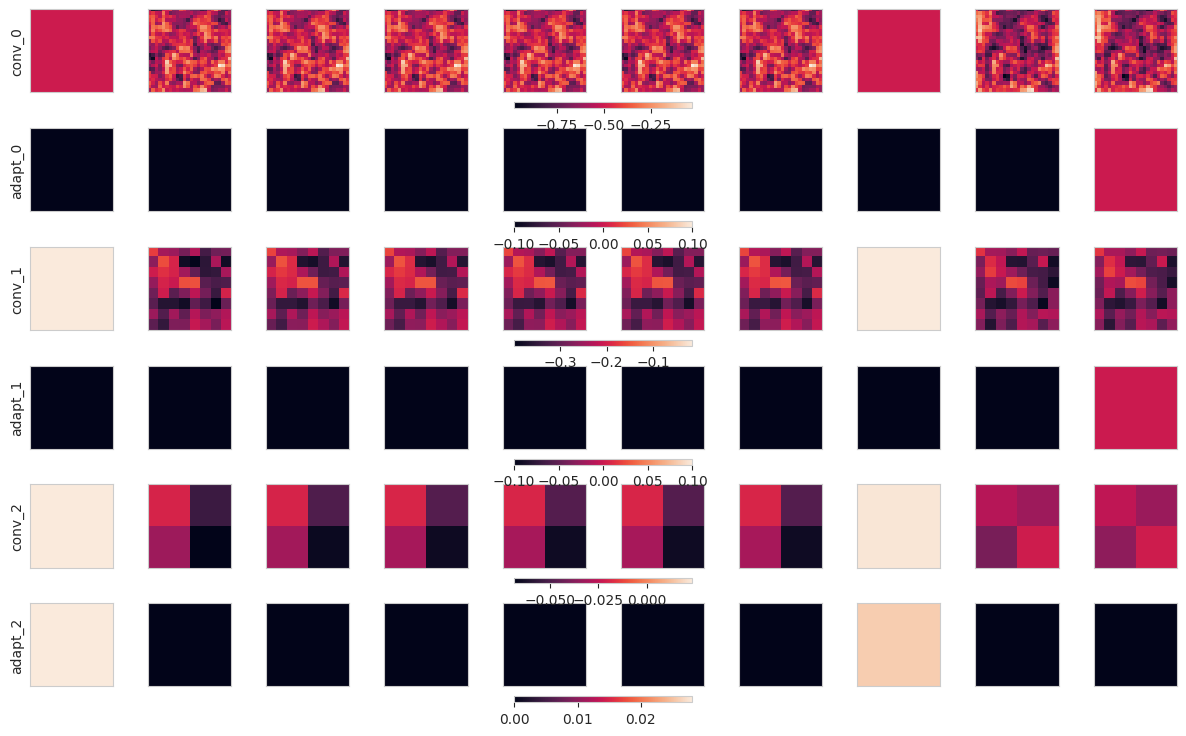

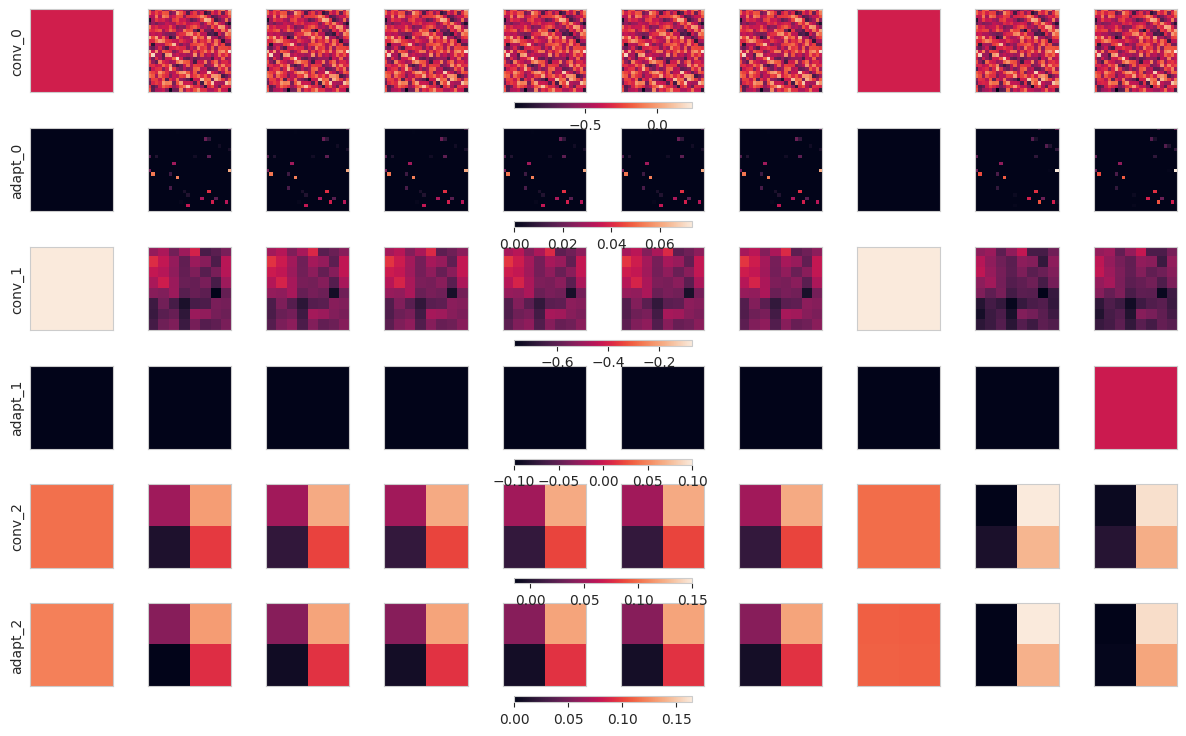

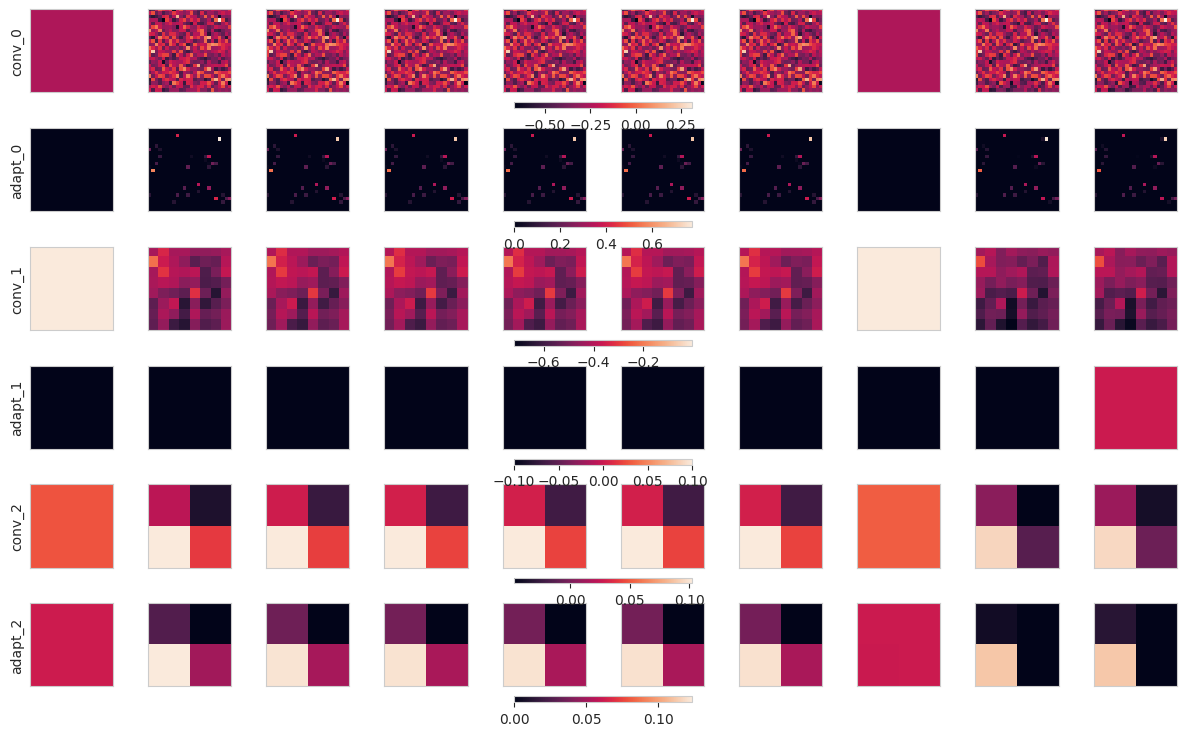

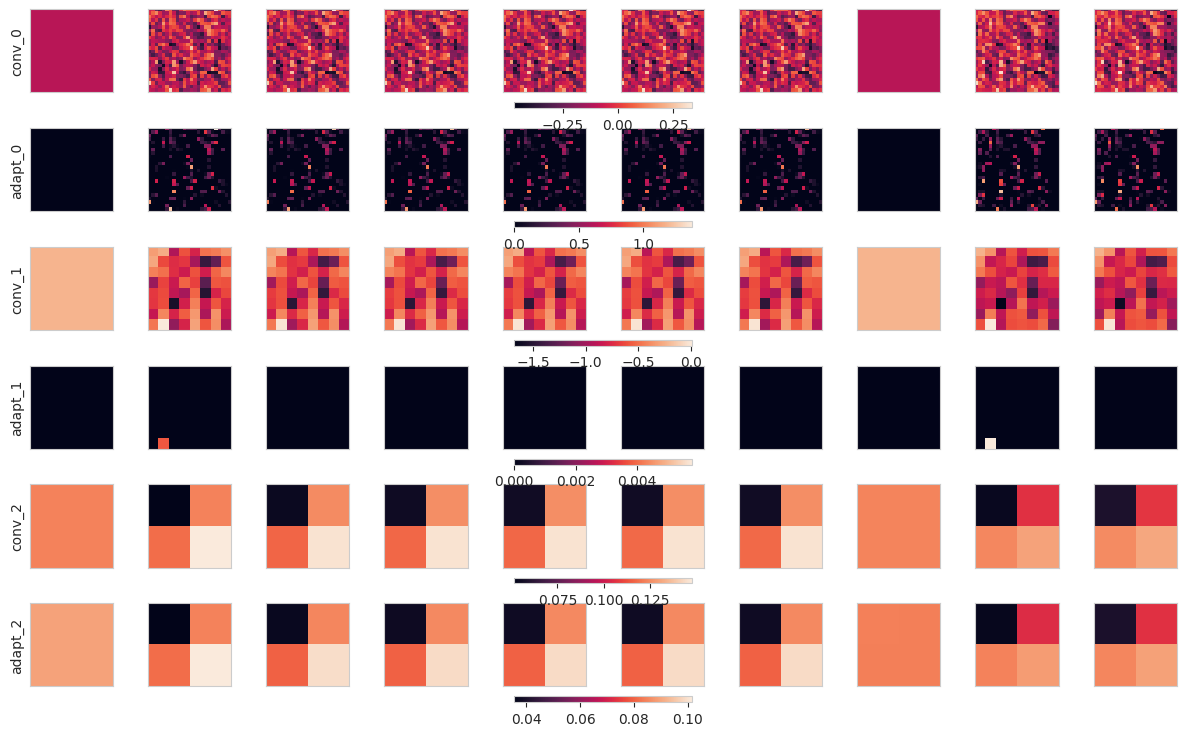

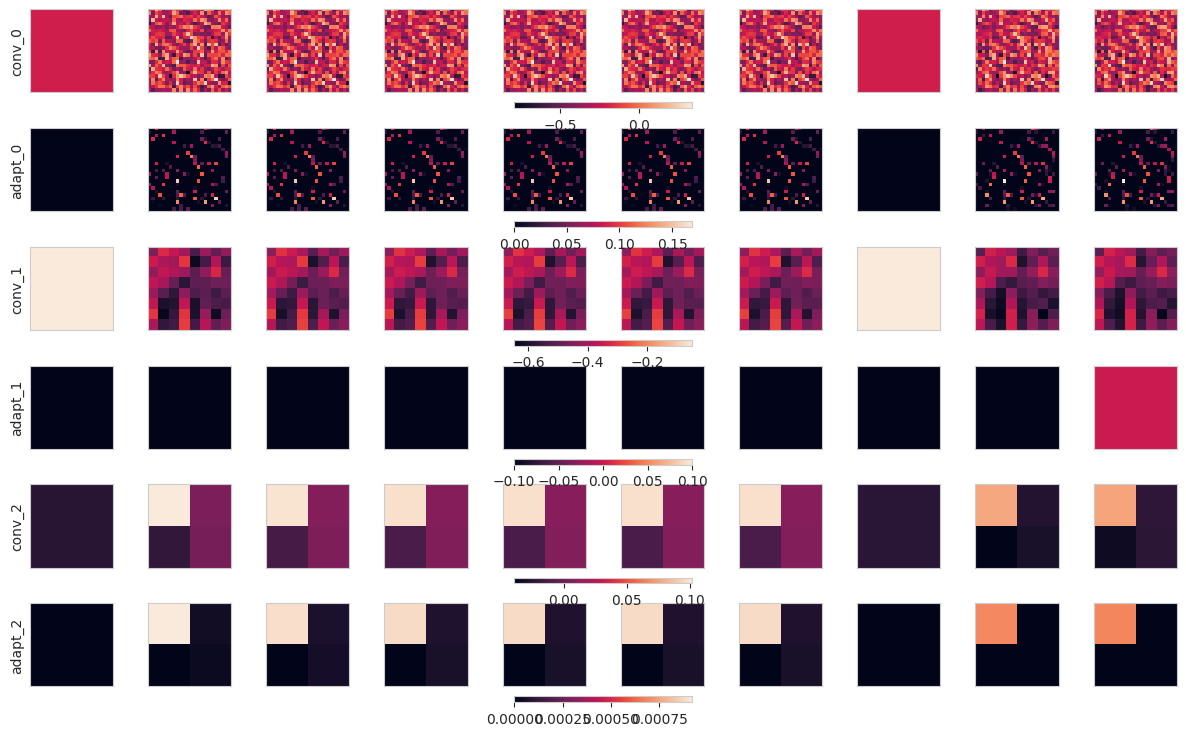

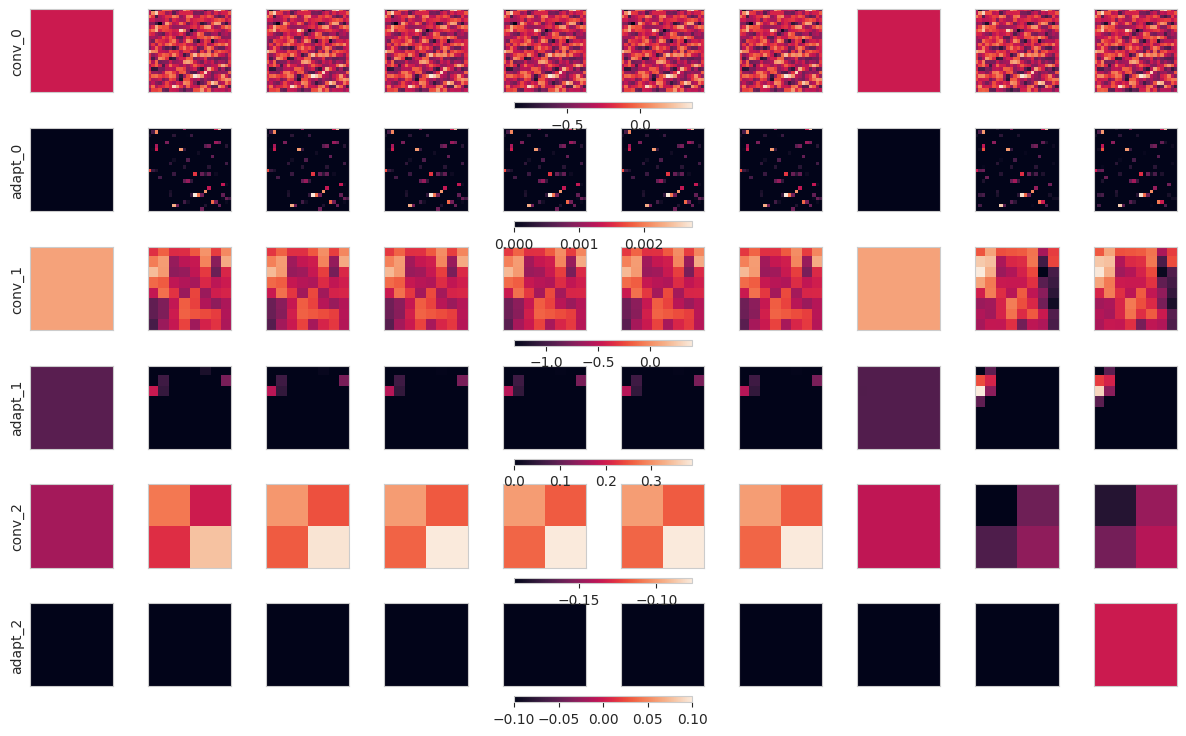

In [17]:
for i in range(8):
    plot_activations(cache_rep, i)
    plt.show()

In [22]:
hooked_model.adapt_layers[2].alpha

Parameter containing:
tensor(0.6693, requires_grad=True)

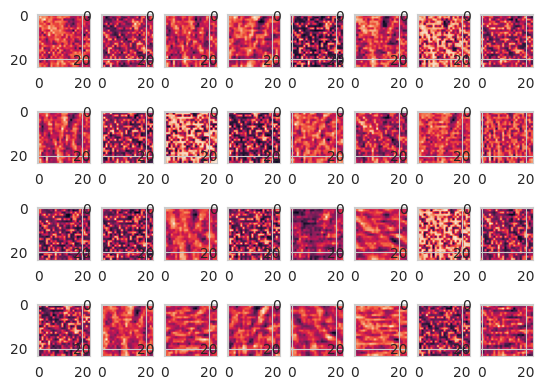

In [14]:
fig, axes = plt.subplots(4, 8)
for i in range(4):
    for j in range(8):
        axes[i, j].imshow(cache['hks.conv_0_1'][0, i * 8 + j].detach().numpy())


In [15]:
cache['hks.conv_0_5'][0, 0].max()

tensor(-0.2764)

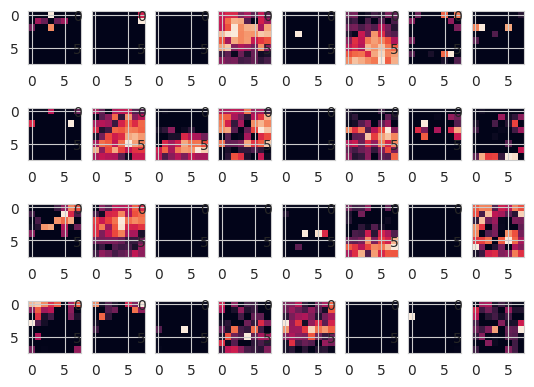

In [18]:
fig, axes = plt.subplots(4, 8)
for i in range(4):
    for j in range(8):
        axes[i, j].imshow(cache['hks.adapt_1_9'][0, i * 8 + j].detach().numpy())


In [17]:
hooked_model.adapt_layers[0].alpha

Parameter containing:
tensor(0.0285, requires_grad=True)

In [18]:
def reduce_cache(cache, hooked_model):
    new_cache = {}
    for layer in range(3):
        new_cache[f'hks.conv_{layer}'] = torch.stack([cache[f'hks.conv_{layer}_{i}'] for i in range(10)], dim=1)
        new_cache[f'hks.adapt_{layer}'] = torch.stack([cache[f'hks.adapt_{layer}_{i}'] for i in range(10)], dim=1)
    for key, value in cache.items():
        if key.startswith('hks.conv_') or key.startswith('hks.adapt_'):
            continue
        new_cache[key] = value
    return new_cache
cache = reduce_cache(cache, hooked_model)
cache['hks.conv_0'].shape

torch.Size([32, 10, 32, 24, 24])

<Axes: >

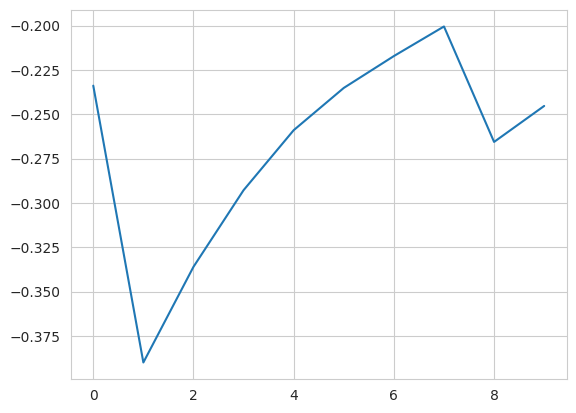

In [19]:
import seaborn as sns
sns.lineplot(cache['hks.conv_2'][0, :, 0, 0, 0].detach().numpy())

In [20]:
from tqdm import tqdm

sum_per_feature = torch.zeros(32,)
for x, y in tqdm(noise_test_dataloader[0]):
    l, cache = hooked_model.run_with_cache(x)
    cache = reduce_cache(cache, hooked_model)
    for i in range(32):
        sum_per_feature[i] += torch.sum(cache['hks.adapt_1'][:, :, i] != 0.)
sum_per_feature

100%|██████████| 313/313 [00:26<00:00, 11.67it/s]


tensor([      0., 4427187.,       0.,       0.,  681500.,       0.,       0.,
              0.,       0.,       0., 4905216., 3194225.,       0.,       0.,
              0., 1126352., 2747498., 1393959.,       0.,       0., 3173326.,
         784756.,       0.,       0., 4944441., 4276055.,       0.,       0.,
              0.,       0., 1839411.,       0.])

Text(0.5, 1.0, 'Divisive Normalization leads to dead feature maps')

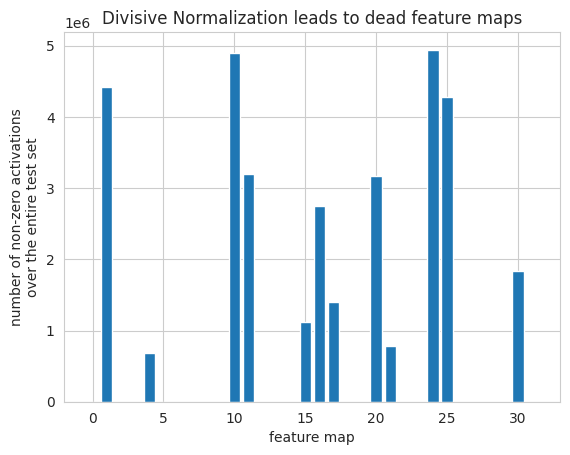

In [21]:
plt.bar(range(32), sum_per_feature)
plt.xlabel('feature map')
plt.ylabel('number of non-zero activations\nover the entire test set')
plt.title('Divisive Normalization leads to dead feature maps')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        7.000e+00, 4.000e+00, 3.000e+00, 1.000e+01, 9.000e+00, 6.000e+00,
        9.000e+00, 1.100e+01, 9.000e+00, 1.000e+01, 1.600e+01, 9.000e+00,
        1.400e+01, 1.600e+01, 2.300e+01, 2.000e+01, 1.900e+01, 3.400e+01,
        3.300e+01, 3.100e+01, 3.000e+01, 3.500e+01, 5.000e+01, 4.900e+01,
        5.800e+01, 8.100e+01, 1.680e+02, 4.830e+02, 1.133e+03, 1.257e+03,
        1.292e+03, 1.246e+03, 1.161e+03, 8.450e+02, 2.670e+02, 1.160e+02,
        8.200e+01, 6.200e+01, 6.100e+01, 6.400e+01, 4.700e+01, 4.700e+01,
        3.000e+01, 3.100e+01, 2.300e+01, 2.200e+01, 3.100e+01, 1.900e+01,
        1.700e+01, 1.600e+01, 1.700e+01, 2.300e+01, 6.000e+00, 6.000e+00,
        7.000e+00, 2.000e+00, 2.000e+0

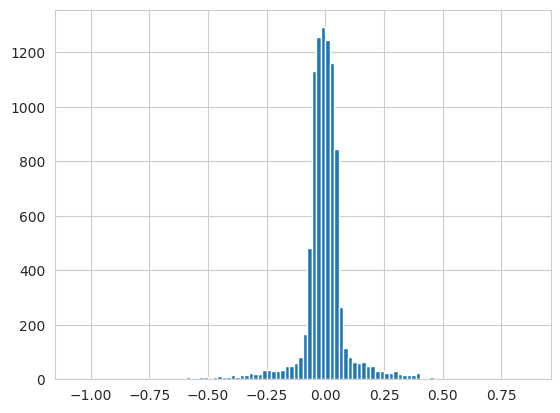

In [22]:
plt.hist(hooked_model.conv_layers[2].weight.flatten().detach().cpu(), 100)

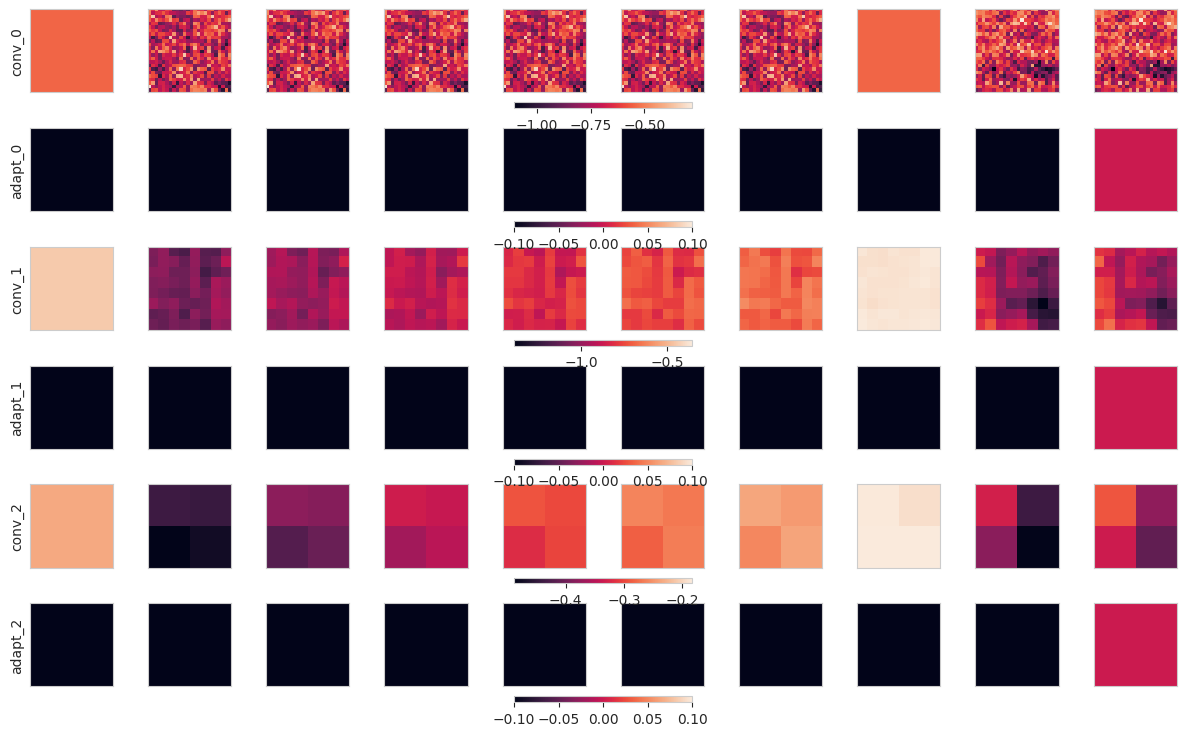

In [23]:
x, y = next(iter(noise_test_dataloader[1]))
l, cache = hooked_model.run_with_cache(x)
plot_activations(cache)